# <center>**Diamond Price Prediction Model**</center>

<img src='diamond_pic.png'>

## **Table of Contents**

1. [Problem Statement](#problem)
2. [Data Loading and Exploration](#data-loading)
3. [Data Visualization in Tableau](#visual)
4. [Data Preprocessing](#data-preprocess)
[<ul>4.1 Numerical Pipeline</ul>](#numeric)
[<ul>4.2 Ordinal Pipeline</ul>](#ordinal)
[<ul>4.3 Custom Transformer</ul>](#custom)
5. [Model Selection and Training](#selection)
[<ul>5.1 Shortlist Promising Models</ul>](#initial)
[<ul>5.2 Fine Tuning</ul>](#fine)
6. [Model Evaluation](#evaluation)
7. [Conclusion](#conclude)
8. [Appendix](#append)

---



## **1. Problem Statement** <a class="anchor" id="problem"></a>

The goal of this analysis is to create a model to predict the price of a diamond using the Diamonds Data set from Kaggle (https://www.kaggle.com/datasets/shivam2503/diamonds).

The dataset author's description of the columns is in the Appendix section.  

## **2. Data Loading and Exploration** <a class="anchor" id="data-loading"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
diamond_data = pd.read_csv('diamond_prices.csv')

In [3]:
diamond_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
diamond_data.shape

(53940, 11)

The dataset contains around 54,000 rows with 11 columns.  However, one of the columns is an extra index column that should be removed.  

In [8]:
diamond_data = diamond_data.drop('Unnamed: 0', axis=1)

In [9]:
diamond_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


The dataset contains both numeric and object data types for the features.  

In [10]:
diamond_data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

The dataset does not contain any missing values.  However, imputer pipelines will still be set up to handle missing values that could come from future data.  

In [11]:
diamond_data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


There are a couple of important points about the descriptive statistics above:

* The carat variable ranges from 0.2 to around 5.  There are definitely diamonds that are larger than 5 carats, but that is a pretty good range.
* The price variable ranges from \\$326 to \\$18,800.  This means that the model will be limited to only predicting the price of diamonds within that range.  

In [16]:
diamond_data['cut'].value_counts(normalize=True)

cut
Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: proportion, dtype: float64

The cut proportions range from 3% to 40% with the more ideal and premium diamonds making up the majority of the data.  This risks the model being less good at predicting the lower grade diamonds.

In [17]:
diamond_data['clarity'].value_counts(normalize=True)

clarity
SI1     0.242214
VS2     0.227253
SI2     0.170449
VS1     0.151483
VVS2    0.093919
VVS1    0.067760
IF      0.033185
I1      0.013737
Name: proportion, dtype: float64

Proportions for clarity range from 1% to 24% with most values falling into the middle values.

In [18]:
diamond_data['color'].value_counts(normalize=True)

color
G    0.209344
E    0.181628
F    0.176900
H    0.153949
D    0.125603
I    0.100519
J    0.052058
Name: proportion, dtype: float64

Color ranges from J as the worst to D as the best.  The proportions of this variable show values ranging from 5% to 20%.  This data is reasonably balanced for this analysis.  

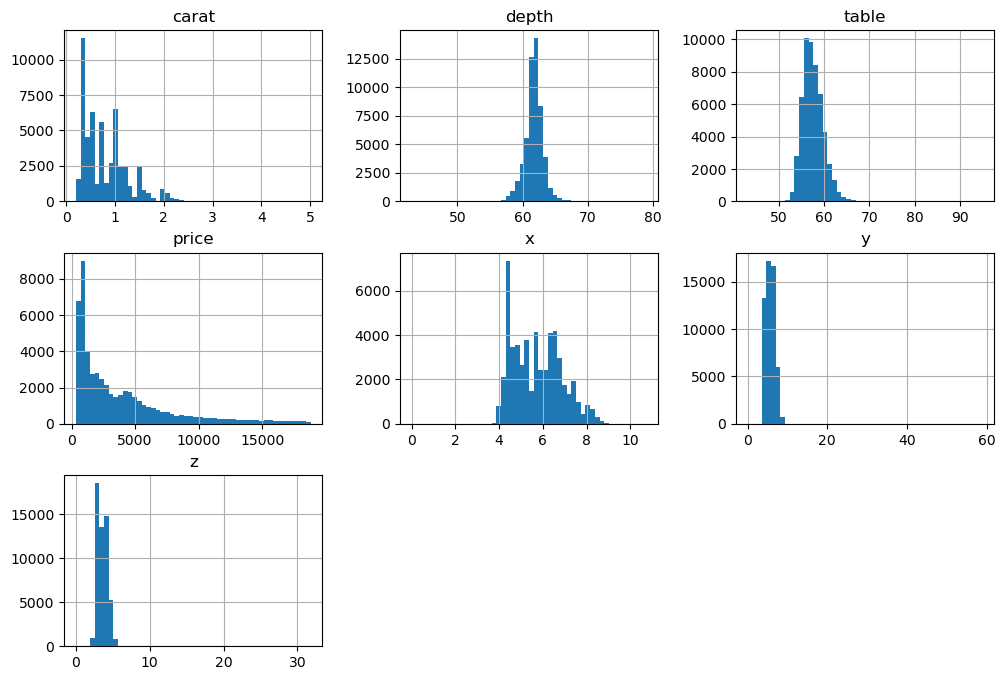

In [24]:
diamond_data.hist(bins=50, figsize=(12, 8))
plt.show()

### Splitting Data into Training and Testing Sets

In [25]:
from sklearn.model_selection import train_test_split

features = diamond_data.drop('price', axis=1)
target = diamond_data['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=10)

### EDA on Training Set

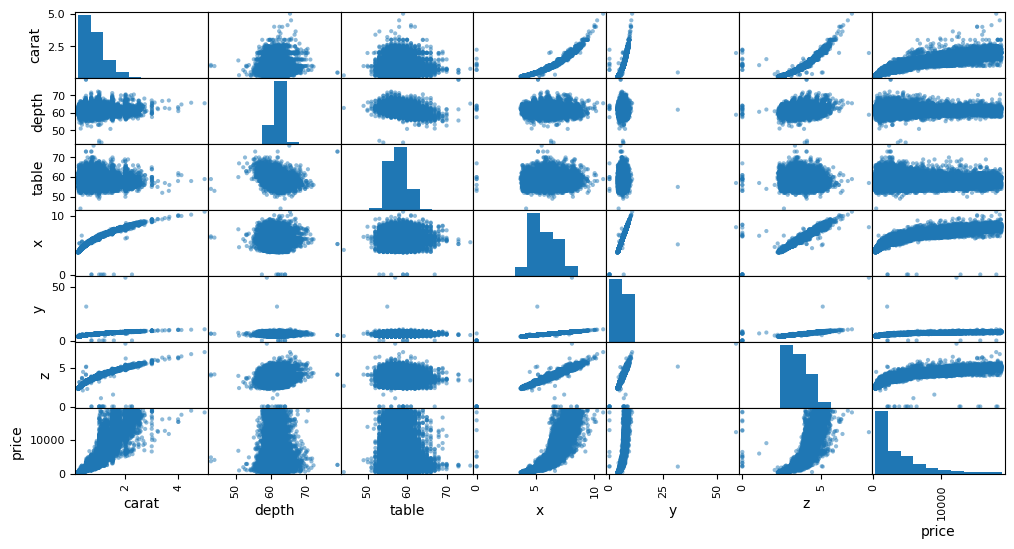

In [27]:
from pandas.plotting import scatter_matrix

scatter_matrix(pd.concat([X_train, y_train], axis=1), figsize=(12, 6))
plt.show()

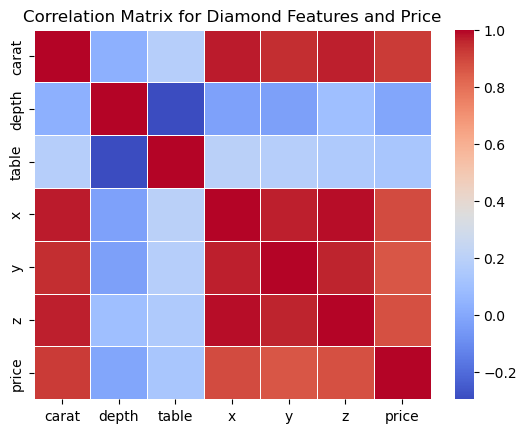

In [31]:
corr_matrix = pd.concat([X_train.select_dtypes('float64'), y_train], axis=1).corr()

sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Diamond Features and Price')
plt.show()

## **3. Data Visualization in Tableau** <a class="anchor" id="visual"></a>

Placeholder

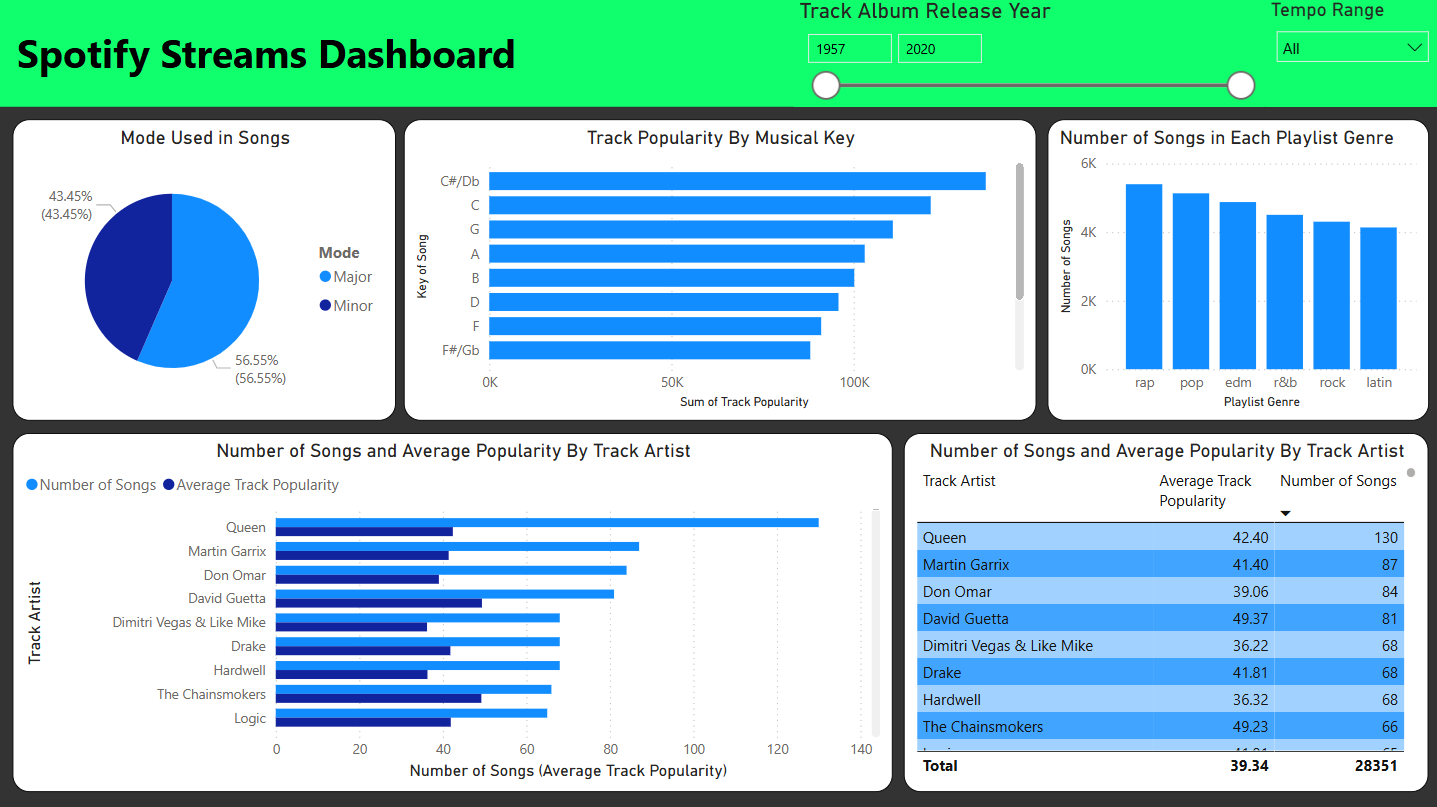

## **4. Data Preprocessing** <a class="anchor" id="data-preprocess"></a>

### Feature Selection

### 4.1 Numerical Pipeline <a class="anchor" id="numeric"></a>

### 4.2 Ordinal Pipeline <a class="anchor" id="ordinal"></a>

### 4.3 Custom Transformer <a class="anchor" id="custom"></a>

## **5. Model Selection and Training** <a class="anchor" id="selection"></a>

### 5.1 Shortlist Promising Models <a class="anchor" id="initial"></a>



### 5.2 Fine Tuning<a class="anchor" id="fine"></a>

---
## **6. Model Evaluation** <a class="anchor" id="evaluation"></a>

---
## **7. Conclusion** <a class="anchor" id="conclude"></a>

---
## **8. Appendix** <a class="anchor" id="append"></a>

The description of the columns from the dataset author's Kaggle post are listed below:

|variable                 |class     |description |
|:---|:---|:-------|
|carat                    |float64   | weight of the diamond |
|cut                      |character | quality of the cut (Fair, Good, Very Good, Premium, Ideal)  |
|color                    |character | diamond color, from J (worst) to D (best)  |
|clarity                  |character | clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) |
|x                        |float64 | length in mm (0--10.74) |
|y                        |float64 | y width in mm (0--58.9) |
|z                        |float64 | z depth in mm (0--31.8) |
|depth                    |float64 | depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79) |
|table                    |float64 | table width of top of diamond relative to widest point (43--95) |
|price                    |int64     | price in US dollars |